#Section 6: Recurrent NN

##Name Classification using RNN

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import random
import io

#Neural Network packages

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import torch.nn.functional as F

# Text packages
import unicodedata
import string

seed = torch.manual_seed(0)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import zipfile
# # unzip image file
# local_zip = '/content/drive/MyDrive/AI-Internship/NameClassification.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content/drive/MyDrive/AI-Internship/NameClassificationn')
# zip_ref.close()

###Data preprocessing

In order to load all files with special address pattern, we use glob library.

In [3]:
import glob
all_text_files = glob.glob('/content/drive/MyDrive/AI-Internship/NameClassificationn/data/names/*.txt')
print(f'First element of all text files is : {all_text_files[0]}')
print(f'length of all text files is: {len(all_text_files)}')

First element of all text files is : /content/drive/MyDrive/AI-Internship/NameClassificationn/data/names/Arabic.txt
length of all text files is: 18


In [4]:
all_letters = string.ascii_letters
n_letters = len(all_letters)
print(f'all letters : {all_letters}')
print(f'length of all letters: {len(all_letters)}')

all letters : abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
length of all letters: 52


Because in some languages like French, names are in unicode form, we should convert them to ascii.

In [5]:
# Fuction for convert names in unicode form to ascii
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Béringer'))

Beringer


We should create a dictionary that keys are languages and values of dictionary are names.

In [6]:
category_lines = {}
all_categories = []

# Read a file and split into lines
# then convert names into ascii and lowercase
def readlines(filename):
  lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicode_to_ascii(line).lower() for line in lines] 

for filename in all_text_files:
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  category_lines[category] = readlines(filename)

print(f'There are {len(all_categories)} languages.')
print(f'first 10 examples of {all_categories[0]} names : {category_lines[all_categories[0]][:10]}')

There are 18 languages.
first 10 examples of Arabic names : ['khoury', 'nahas', 'daher', 'gerges', 'nazari', 'maalouf', 'gerges', 'naifeh', 'guirguis', 'baba']


In [7]:
num_names = 0
for i in all_categories:
  num_names += len(category_lines[i])

print(f'Number of all names : {num_names}')

Number of all names : 20074


#####Convert names to pytorch tensors

In [8]:
# one hot encoding for a letter
# Find letter index from all_letters
def letter_to_index(letter):
  return all_letters.find(letter)
  
# Turn a line into a <line_length x 1 x n_letters>
def line_to_tensor(line):
  tensor = torch.zeros(len(line), 1, int(n_letters/2)) # because we have lowercase names
  for i, letter in enumerate(line):
    tensor[i][0][letter_to_index(letter)] = 1
  return tensor
    
print(line_to_tensor('a'))
print(line_to_tensor('a').size())

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
torch.Size([1, 1, 26])


###Buliding RNN

In [15]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size , hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1)

    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self):#####
    return torch.rand(1, self.hidden_size)  


####Testing model

In [16]:
n_hidden = 128
rnn = RNN(int(n_letters/2), n_hidden, len(all_categories))

#one step
input_tensor = line_to_tensor('albert')
hidden_tensor = rnn.init_hidden() 

output, next_hidden = rnn(input_tensor[0], hidden_tensor)

print(f'input tensor size: {input_tensor.size()}')
print(f'hidden tensor size : {hidden_tensor.size()}')

print(f'output size : {output.size()}')
print(f'next hidden size : {next_hidden.size()}')

input tensor size: torch.Size([6, 1, 26])
hidden tensor size : torch.Size([1, 128])
output size : torch.Size([1, 18])
next hidden size : torch.Size([1, 128])


In [17]:
output

tensor([[-2.9525, -2.5677, -2.8309, -2.7509, -3.0638, -2.7127, -3.0615, -2.6954,
         -2.7440, -2.7990, -2.9442, -3.5382, -2.9408, -3.2513, -3.0061, -2.8617,
         -3.0727, -2.6669]], grad_fn=<LogSoftmaxBackward>)

In [18]:
torch.argmax(output).item()

1

###Preparing for training

In order to get index of maximum value in output we use the following funciton.

In [19]:
def category_form_output(output):
  index = torch.argmax(output).item()
  return all_categories[index]

print(category_form_output(output))

Chinese


In [20]:
def randomChoice(lst):
  return lst[random.randint(0, len(lst)-1)]

def randomTrainingExample(): #####
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(5):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print(f'cateogry = {category} | line : {line} |category_tensor size : {category_tensor.size()} | line tensor size : {line_tensor.size()}' )
  

cateogry = Portuguese | line : pinheiro |category_tensor size : torch.Size([1]) | line tensor size : torch.Size([8, 1, 26])
cateogry = Korean | line : cha |category_tensor size : torch.Size([1]) | line tensor size : torch.Size([3, 1, 26])
cateogry = Vietnamese | line : huynh |category_tensor size : torch.Size([1]) | line tensor size : torch.Size([5, 1, 26])
cateogry = English | line : angus |category_tensor size : torch.Size([1]) | line tensor size : torch.Size([5, 1, 26])
cateogry = Korean | line : lee |category_tensor size : torch.Size([1]) | line tensor size : torch.Size([3, 1, 26])


Define a function for finding category of a name.

In [22]:
def find_name(name):
  for i in all_categories:
    if name in category_lines[i]:
      print(i)

In [25]:
find_name('huynh')

Vietnamese


###Training the model

problem start from here.

In [26]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.Adam(rnn.parameters(), lr = learning_rate)
scheduler = StepLR(optimizer, step_size = 50, gamma = 0.1)

In [27]:
def train(line_tensor, category_tensor):
  hidden = rnn.init_hidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  optimizer.zero_grad()
  loss.backward()   
  optimizer.step()

  return output, loss.item()

In [28]:
from tqdm import tqdm 

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_epoch = 100000

for i in tqdm(range(n_epoch)):
  category, line, category_tensor, line_tensor = randomTrainingExample()

  output, loss = train(line_tensor, category_tensor)
  current_loss += loss

  scheduler.step() ##

  if (i+1) % plot_steps ==0:
    all_losses.append(current_loss/plot_steps)
    current_loss = 0

  if (i+1) % print_steps ==0:
    guess = category_form_output(output)
    correct = "CORRECT" if guess == category else f"WRONG ({category})"
    print(f'Epoch : {i+1} |percentage : {(i+1)/n_epoch*100} |loss: {loss:.4f} |line: {line} / guess : {guess} {correct}')  



  5%|▌         | 5075/100000 [00:07<02:19, 682.62it/s]

Epoch : 5000 |percentage : 5.0 |loss: 3.0246 |line: kringos / guess : Portuguese WRONG (Greek)


 10%|█         | 10097/100000 [00:14<02:09, 692.30it/s]

Epoch : 10000 |percentage : 10.0 |loss: 2.9355 |line: amello / guess : English WRONG (Italian)


 15%|█▌        | 15119/100000 [00:22<02:03, 689.39it/s]

Epoch : 15000 |percentage : 15.0 |loss: 2.1196 |line: grzeskiewicz / guess : Polish CORRECT


 20%|██        | 20133/100000 [00:29<01:55, 693.55it/s]

Epoch : 20000 |percentage : 20.0 |loss: 2.9400 |line: ramsay / guess : English WRONG (Scottish)


 25%|██▌       | 25128/100000 [00:36<01:47, 695.15it/s]

Epoch : 25000 |percentage : 25.0 |loss: 2.7791 |line: morrison / guess : Polish WRONG (Scottish)


 30%|███       | 30112/100000 [00:43<01:38, 708.81it/s]

Epoch : 30000 |percentage : 30.0 |loss: 2.5194 |line: paszek / guess : English WRONG (Polish)


 35%|███▌      | 35080/100000 [00:51<01:33, 697.69it/s]

Epoch : 35000 |percentage : 35.0 |loss: 2.9714 |line: smets / guess : Chinese WRONG (Dutch)


 40%|████      | 40109/100000 [00:58<01:27, 680.68it/s]

Epoch : 40000 |percentage : 40.0 |loss: 3.6436 |line: maria / guess : Chinese WRONG (Italian)


 45%|████▌     | 45120/100000 [01:05<01:20, 683.13it/s]

Epoch : 45000 |percentage : 45.0 |loss: 3.2532 |line: zhenin / guess : English WRONG (Russian)


 50%|█████     | 50130/100000 [01:13<01:11, 699.24it/s]

Epoch : 50000 |percentage : 50.0 |loss: 2.7496 |line: hanania / guess : Portuguese WRONG (Arabic)


 55%|█████▌    | 55135/100000 [01:20<01:07, 666.68it/s]

Epoch : 55000 |percentage : 55.00000000000001 |loss: 2.5030 |line: tyman / guess : Korean WRONG (English)


 60%|██████    | 60107/100000 [01:27<00:56, 700.29it/s]

Epoch : 60000 |percentage : 60.0 |loss: 3.4666 |line: riha / guess : Korean WRONG (Czech)


 65%|██████▌   | 65111/100000 [01:34<00:51, 675.08it/s]

Epoch : 65000 |percentage : 65.0 |loss: 3.1267 |line: colman / guess : English WRONG (Irish)


 70%|███████   | 70119/100000 [01:42<00:45, 660.09it/s]

Epoch : 70000 |percentage : 70.0 |loss: 1.6806 |line: le / guess : Vietnamese CORRECT


 75%|███████▌  | 75084/100000 [01:49<00:38, 645.51it/s]

Epoch : 75000 |percentage : 75.0 |loss: 2.9612 |line: mitchell / guess : Italian WRONG (Scottish)


 80%|████████  | 80074/100000 [01:56<00:28, 699.73it/s]

Epoch : 80000 |percentage : 80.0 |loss: 2.5857 |line: salib / guess : Chinese WRONG (Arabic)


 85%|████████▌ | 85103/100000 [02:03<00:21, 688.19it/s]

Epoch : 85000 |percentage : 85.0 |loss: 2.9322 |line: ondrisek / guess : Polish WRONG (Czech)


 90%|█████████ | 90139/100000 [02:10<00:14, 702.36it/s]

Epoch : 90000 |percentage : 90.0 |loss: 3.1043 |line: colman / guess : English WRONG (Irish)


 95%|█████████▌| 95085/100000 [02:18<00:07, 699.29it/s]

Epoch : 95000 |percentage : 95.0 |loss: 4.5309 |line: jaso / guess : Vietnamese WRONG (Spanish)


100%|██████████| 100000/100000 [02:25<00:00, 687.87it/s]

Epoch : 100000 |percentage : 100.0 |loss: 2.8507 |line: jaskulski / guess : Portuguese WRONG (Polish)


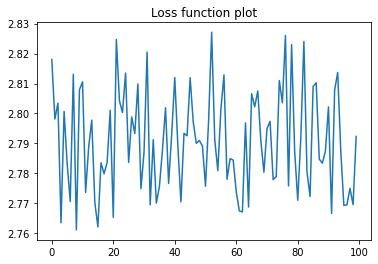

In [29]:
plt.figure()
plt.plot(all_losses)
plt.title('Loss function plot')
plt.show()

In [30]:
scheduler.state_dict()

{'_get_lr_called_within_step': False,
 '_last_lr': [0.0],
 '_step_count': 100001,
 'base_lrs': [0.005],
 'gamma': 0.1,
 'last_epoch': 100000,
 'step_size': 50,
 'verbose': False}

In [31]:
y_actual = []
y_pred = []
n_total = 10000

with torch.no_grad():
  n_true = 0
  n_class_correct = [0 for i in range(18)]
  n_class_sample = [0 for i in range(18)]

  for i in tqdm(range(n_total)):
    category, line, category_tensor, line_tensor = randomTrainingExample()

    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
      output, hidden = rnn(line_tensor[i], hidden)

      guess = category_form_output(output)
      y_pred.append(all_categories.index(guess))
      y_actual.append(all_categories.index(category))

      n_true += (guess == category)
      if guess == category :
        n_class_correct[all_categories.index(category)] += 1
      n_class_sample[all_categories.index(category)] += 1
      
  print(f'accuracy of network on the 1000 names is : {(n_true/n_total) *100}')
  
  for i in range(18):
    if n_class_sample[i] != 0:
      acc = 100.0 * n_class_correct[i] / n_class_sample[i]
      print(f'Accuracy of {all_categories[i]}: {acc} %')
  

100%|██████████| 10000/10000 [00:04<00:00, 2000.03it/s]

accuracy of network on the 1000 names is : 30.39
Accuracy of Arabic: 0.16989466530750935 %
Accuracy of Chinese: 1.9854721549636805 %
Accuracy of Czech: 1.132991637442676 %
Accuracy of Dutch: 0.0 %
Accuracy of English: 10.225921521997622 %
Accuracy of French: 0.22290331568682084 %
Accuracy of German: 0.5651237890204521 %
Accuracy of Greek: 1.107375914573858 %
Accuracy of Irish: 6.737967914438503 %
Accuracy of Italian: 4.485749690210657 %
Accuracy of Japanese: 1.6881028938906752 %
Accuracy of Korean: 35.17045454545455 %
Accuracy of Polish: 7.837837837837838 %
Accuracy of Portuguese: 3.124151045911437 %
Accuracy of Russian: 0.13452914798206278 %
Accuracy of Scottish: 3.84932636788562 %
Accuracy of Spanish: 5.0892619237942975 %
Accuracy of Vietnamese: 33.45070422535211 %


###Confusion matrix

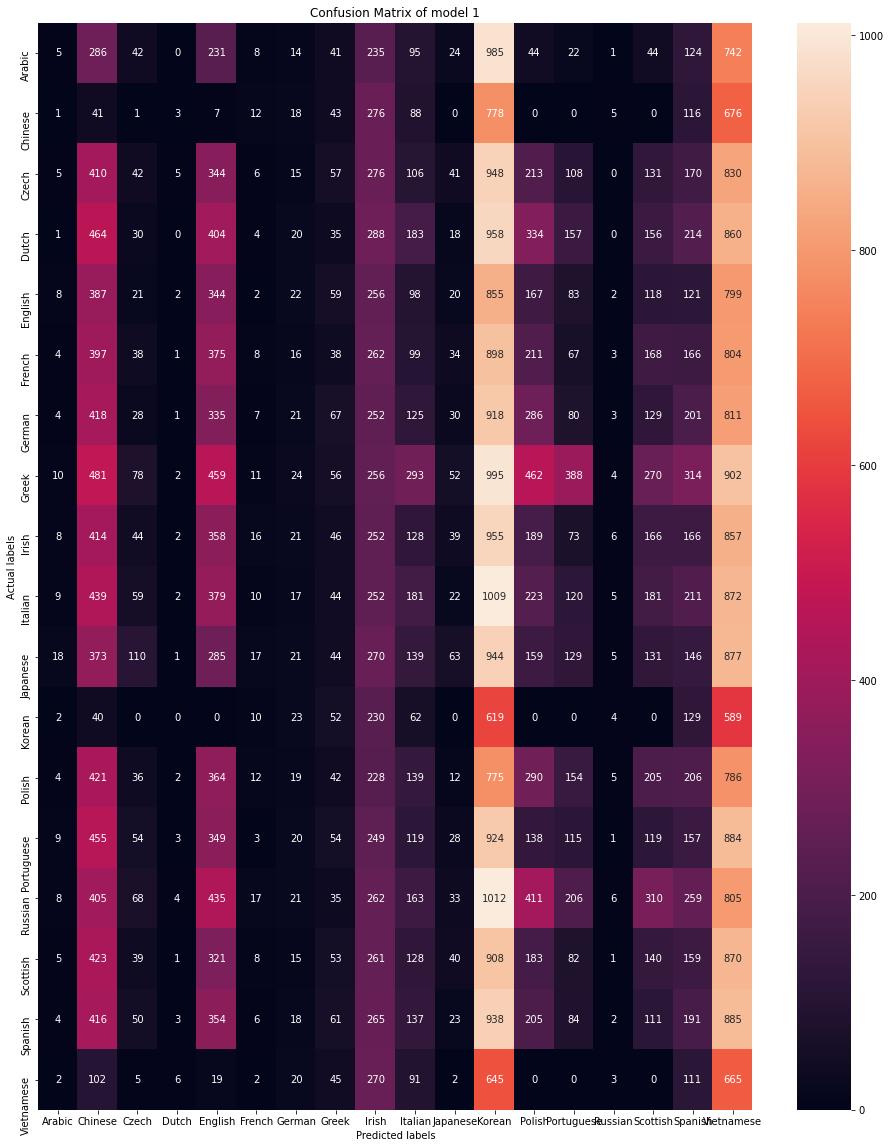

In [32]:
from sklearn import metrics
import seaborn as sns

plt.figure(figsize = (16, 20))
ax= plt.subplot()
cnf_matrix = metrics.confusion_matrix(y_actual, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix of model 1'); 
class_names=['Arabic','Chinese','Czech','Dutch','English','French','German','Greek','Irish','Italian','Japanese','Korean','Polish','Portuguese','Russian','Scottish','Spanish','Vietnamese']
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

###Classification report

In [33]:
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.05      0.00      0.00      2943
           1       0.01      0.02      0.01      2065
           2       0.06      0.01      0.02      3707
           3       0.00      0.00      0.00      4126
           4       0.06      0.10      0.08      3364
           5       0.05      0.00      0.00      3589
           6       0.06      0.01      0.01      3716
           7       0.06      0.01      0.02      5057
           8       0.05      0.07      0.06      3740
           9       0.08      0.04      0.06      4035
          10       0.13      0.02      0.03      3732
          11       0.04      0.35      0.07      1760
          12       0.08      0.08      0.08      3700
          13       0.06      0.03      0.04      3681
          14       0.11      0.00      0.00      4460
          15       0.06      0.04      0.05      3637
          16       0.06      0.05      0.06      3753
          17       0.05    

In [34]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_form_output(output)
        print(guess)

In [39]:
predict('aalst')


> aalst
Korean


##MNIST Digits classification using RNN, GRU and LSTM

In [22]:
# MNIST dataset from pytorch

train_dataset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/AI-Internship/MNIST', train = True, transform = transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/AI-Internship/MNIST', train = False, transform = transforms.ToTensor(),download=True)


In [23]:
input_size = 28 # 28X28 images, we treat it as a sequence
sequence_length = 28
num_layers = 2

hidden_size = 128
num_classes = 10 
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [24]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [25]:
print(f'length of train_dataset is : {len(train_dataset)} and length of train_loader is : {len(train_loader)}')
print(f'length of test_dataset is : {len(test_dataset)} and length of test_loader is : {len(test_loader)}')

length of train_dataset is : 60000 and length of train_loader is : 600
length of test_dataset is : 10000 and length of test_loader is : 100
